## 📦 Setup & Import Libraries


In [53]:
!pip install -q tensorflow>=2.15.0 kaggle opendatasets scikit-learn matplotlib seaborn tqdm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import shutil
from pathlib import Path
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm
import time

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

# Check for GPU (will use if available, but notebook optimized for CPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
    print("   Note: This notebook is optimized for CPU, but will use GPU if available")
    # Enable memory growth to prevent OOM
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("💻 No GPU detected - training on CPU")
    print("   Expected time: 8-13 hours total")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Session timing
SESSION_START_TIME = datetime.now()
print(f"\n⏱️ Session started: {SESSION_START_TIME.strftime('%H:%M:%S')}")

TensorFlow version: 2.20.0
NumPy version: 2.2.6
💻 No GPU detected - training on CPU
   Expected time: 8-13 hours total

⏱️ Session started: 14:53:15



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 🔑 Configuration - SET YOUR LOCAL PATHS HERE

**👉 EDIT THESE PATHS TO MATCH YOUR LOCAL SYSTEM:**


In [54]:
# =============================================================
# 🔧 LOCAL CONFIGURATION - DATASET FOLDERS
# =============================================================

from pathlib import Path

# Base datasets folder
DATASETS_ROOT = Path("datasets").resolve()

# Path to leaf nutrient datasets
NUTRIENT_DATASETS_ROOT = DATASETS_ROOT / "Leaf Nutrient Data Sets"

# Path to PlantVillage dataset
PLANTVILLAGE_PATH = DATASETS_ROOT / "PlantVillage"

# Path to kaggle.json (for Kaggle API)
KAGGLE_JSON_PATH = DATASETS_ROOT / "kaggle.json"

# Output directory for models and checkpoints
OUTPUT_DIR = Path("unified_savedmodel_output").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 🌾 Crop datasets to include (4-crop MVP)
CROP_DATASETS = {
    'rice': 'Rice Nutrients',
    'wheat': 'Wheat Nitrogen',
    'tomato': 'Tomato Nutrients',
    'maize': 'Maize Nutrients',
}

# Ensure all required folders exist
DATASETS_ROOT.mkdir(parents=True, exist_ok=True)
NUTRIENT_DATASETS_ROOT.mkdir(parents=True, exist_ok=True)
PLANTVILLAGE_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# =============================================================
# 🎯 CPU-OPTIMIZED TRAINING SETTINGS
# =============================================================
IMG_SIZE = 224
BATCH_SIZE = 8  # Reduced for CPU (GPU uses 32)

# Epochs - reduced for faster CPU training
# Note: You can increase these if you want better accuracy and have time
PLANTVILLAGE_EPOCHS = 5   # Stage 2: Takes ~3-5 hours on CPU
UNIFIED_EPOCHS = 10       # Stage 3: Takes ~5-8 hours on CPU

# Learning rates
LEARNING_RATE_STAGE2 = 1e-3
LEARNING_RATE_STAGE3 = 5e-4

# Regularization
DROPOUT_RATE = 0.3

# CPU-specific optimizations
NUM_WORKERS = min(os.cpu_count(), 4)  # Limit workers to avoid overhead
PREFETCH_BUFFER = 2  # Small prefetch for CPU

# Use float32 (no mixed precision on CPU)
tf.keras.mixed_precision.set_global_policy('float32')
print("✅ Using float32 policy")

# =============================================================
# 📊 CONFIGURATION SUMMARY
# =============================================================
print("\n" + "="*70)
print("💻 LOCAL CPU TRAINING CONFIGURATION")
print("="*70)
print(f"🌾 Crops: {len(CROP_DATASETS)} ({', '.join(CROP_DATASETS.keys())})")
print(f"\n📁 Data Paths:")
print(f"   Nutrient datasets: {NUTRIENT_DATASETS_ROOT}")
print(f"   PlantVillage: {PLANTVILLAGE_PATH}")
print(f"   Output: {OUTPUT_DIR}")
print(f"   Kaggle JSON: {KAGGLE_JSON_PATH}")
print(f"\n🎯 Training Settings:")
print(f"   Image size: {IMG_SIZE}×{IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE} (CPU optimized)")
print(f"   CPU workers: {NUM_WORKERS}")
print(f"   Stage 2 epochs: {PLANTVILLAGE_EPOCHS}")
print(f"   Stage 3 epochs: {UNIFIED_EPOCHS}")
print(f"\n⏱️ Expected Time:")
print(f"   Stage 2: ~{PLANTVILLAGE_EPOCHS * 40}-{PLANTVILLAGE_EPOCHS * 60} min")
print(f"   Stage 3: ~{UNIFIED_EPOCHS * 40}-{UNIFIED_EPOCHS * 60} min")
print(f"   Total: ~{(PLANTVILLAGE_EPOCHS + UNIFIED_EPOCHS) * 40 // 60}-{(PLANTVILLAGE_EPOCHS + UNIFIED_EPOCHS) * 60 // 60} hours")
print("="*70 + "\n")

✅ Using float32 policy

💻 LOCAL CPU TRAINING CONFIGURATION
🌾 Crops: 4 (rice, wheat, tomato, maize)

📁 Data Paths:
   Nutrient datasets: E:\FasalVaidya\datasets\Leaf Nutrient Data Sets
   PlantVillage: E:\FasalVaidya\datasets\PlantVillage
   Output: E:\FasalVaidya\unified_savedmodel_output
   Kaggle JSON: E:\FasalVaidya\datasets\kaggle.json

🎯 Training Settings:
   Image size: 224×224
   Batch size: 8 (CPU optimized)
   CPU workers: 4
   Stage 2 epochs: 5
   Stage 3 epochs: 10

⏱️ Expected Time:
   Stage 2: ~200-300 min
   Stage 3: ~400-600 min
   Total: ~10-15 hours



## 🚀 Optimized Data Pipeline for CPU


In [55]:
# =============================================================
# 📦 CPU-OPTIMIZED DATA PIPELINE
# =============================================================

AUTOTUNE = tf.data.AUTOTUNE

def create_dataset(data_dir, img_size, batch_size, validation_split=0.2, subset=None):
    """Create dataset from directory"""
    print(f"📦 Loading {subset} data from {os.path.basename(data_dir)}...")
    
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset=subset,
        seed=42,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True
    )
    
    return dataset

@tf.function
def augment_image(image, label):
    """Light augmentation for CPU training"""
    # Random flip
    image = tf.image.random_flip_left_right(image)
    
    # Brightness and contrast
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    
    # Clip values
    image = tf.clip_by_value(image, 0.0, 255.0)
    
    return image, label

@tf.function
def normalize_for_mobilenet(image, label):
    """Normalize to MobileNetV2 input range [-1, 1]"""
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def build_pipeline(dataset, is_training=True):
    """Build CPU-optimized pipeline"""
    
    # Light augmentation for training
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=NUM_WORKERS)
    
    # Normalize
    dataset = dataset.map(normalize_for_mobilenet, num_parallel_calls=NUM_WORKERS)
    
    # Small prefetch for CPU
    dataset = dataset.prefetch(buffer_size=PREFETCH_BUFFER)
    
    return dataset

# =============================================================
# 📊 PROGRESS CALLBACK
# =============================================================
class CPUProgressCallback(tf.keras.callbacks.Callback):
    """Progress tracking optimized for CPU training"""
    
    def __init__(self, total_epochs, stage_name="Training"):
        super().__init__()
        self.total_epochs = total_epochs
        self.stage_name = stage_name
        self.epoch_times = []
        self.start_time = None
    
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        print(f"\n🚀 {self.stage_name} Started")
        print(f"   Epochs: {self.total_epochs}")
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
        print(f"\n📈 Epoch {epoch+1}/{self.total_epochs}")
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        self.epoch_times.append(epoch_time)
        
        # Calculate ETA
        avg_time = np.mean(self.epoch_times)
        remaining = self.total_epochs - (epoch + 1)
        eta_seconds = remaining * avg_time
        eta = str(timedelta(seconds=int(eta_seconds)))
        
        # Progress
        val_acc = logs.get('val_accuracy', 0)
        val_loss = logs.get('val_loss', 0)
        train_acc = logs.get('accuracy', 0)
        
        print(f"   ✅ Complete: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss:.4f}")
        print(f"   ⏱️ Time: {epoch_time:.1f}s | Avg: {avg_time:.1f}s | ETA: {eta}")
    
    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"\n✅ {self.stage_name} Complete!")
        print(f"   Total time: {str(timedelta(seconds=int(total_time)))}")
        print(f"   Avg epoch: {np.mean(self.epoch_times):.1f}s")

print("✅ Data pipeline functions ready")

✅ Data pipeline functions ready


## 🌱 Stage 2: PlantVillage Training (OPTIONAL)

**⚠️ This stage takes 3-5 hours on CPU!**

You can skip this and go directly to Stage 3 if:

- You want faster training
- You already have a Stage 2 checkpoint
- You're okay with slightly lower accuracy

**To skip:** Just run the cell that creates the Stage 2 model without training.


## 📥 Download PlantVillage Dataset (Optional)

If you don't have PlantVillage dataset locally, you can download it from Kaggle.

**Requirements:**

1. Kaggle account
2. Kaggle API key (`kaggle.json`)

**To get kaggle.json:**

1. Go to https://www.kaggle.com/settings
2. Scroll to "API" section
3. Click "Create New Token"
4. Place `kaggle.json` in: `~/.kaggle/` (Linux/Mac) or `C:\Users\YourName\.kaggle\` (Windows)


In [56]:
# =============================================================
# 📥 DOWNLOAD PLANTVILLAGE DATASET FROM KAGGLE
# =============================================================

import zipfile
import subprocess

def download_plantvillage():
    """Download PlantVillage dataset from Kaggle with progress tracking"""
    
    # Check if already exists
    if PLANTVILLAGE_PATH.exists():
        # Check if it has data
        try:
            subdirs = [d for d in PLANTVILLAGE_PATH.iterdir() if d.is_dir()]
            if len(subdirs) > 10:  # PlantVillage has ~38 classes
                print("✅ PlantVillage dataset already exists!")
                print(f"   Location: {PLANTVILLAGE_PATH.relative_to(NOTEBOOK_DIR)}")
                print(f"   Classes found: {len(subdirs)}")
                return True
            else:
                print("⚠️ PlantVillage folder exists but seems incomplete")
                print("   Will re-download...")
        except:
            pass
    
    print("📥 Downloading PlantVillage dataset from Kaggle...")
    print("   This may take 5-10 minutes (~1-2 GB)")
    
    # Check for Kaggle credentials
    kaggle_config = Path.home() / '.kaggle' / 'kaggle.json'
    if not kaggle_config.exists():
        print("\n❌ Kaggle credentials not found!")
        print(f"   Expected: {kaggle_config}")
        print("\n📝 To set up:")
        print("   1. Go to https://www.kaggle.com/settings")
        print("   2. Scroll to 'API' section")
        print("   3. Click 'Create New Token'")
        print(f"   4. Place kaggle.json in: {kaggle_config.parent}")
        print("\n⏩ Skipping download - you can manually download from:")
        print("   https://www.kaggle.com/datasets/arjuntejaswi/plant-village")
        return False
    
    try:
        # Install kaggle package if not available
        try:
            import kaggle
        except ImportError:
            print("📦 Installing kaggle package...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaggle"])
            import kaggle
        
        # Create parent directory
        PLANTVILLAGE_PATH.parent.mkdir(parents=True, exist_ok=True)
        
        # Download dataset
        print("\n⬇️ Downloading from Kaggle...")
        download_path = PLANTVILLAGE_PATH.parent
        
        # Download using kaggle API
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        
        print("   Downloading arjuntejaswi/plant-village...")
        api.dataset_download_files(
            'arjuntejaswi/plant-village',
            path=str(download_path),
            unzip=False
        )
        
        # Find downloaded zip file
        zip_file = download_path / 'plant-village.zip'
        if not zip_file.exists():
            # Try alternative name
            zip_files = list(download_path.glob('*.zip'))
            if zip_files:
                zip_file = zip_files[0]
            else:
                print("❌ Downloaded file not found!")
                return False
        
        print(f"\n📦 Extracting {zip_file.name}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            # Extract all files
            zip_ref.extractall(download_path)
        
        # Find extracted folder (might be nested)
        possible_dirs = [
            download_path / 'PlantVillage',
            download_path / 'plant-village',
            download_path / 'Plant_Village',
        ]
        
        extracted_dir = None
        for d in possible_dirs:
            if d.exists():
                extracted_dir = d
                break
        
        # If not found, look for any directory with many subdirectories
        if not extracted_dir:
            for d in download_path.iterdir():
                if d.is_dir() and d.name not in ['unified_nutrient_dataset', 'local_training']:
                    subdirs = [x for x in d.iterdir() if x.is_dir()]
                    if len(subdirs) > 10:
                        extracted_dir = d
                        break
        
        if extracted_dir and extracted_dir != PLANTVILLAGE_PATH:
            # Rename to expected path
            if PLANTVILLAGE_PATH.exists():
                shutil.rmtree(PLANTVILLAGE_PATH)
            extracted_dir.rename(PLANTVILLAGE_PATH)
            print(f"✅ Renamed to: {PLANTVILLAGE_PATH.relative_to(NOTEBOOK_DIR)}")
        
        # Clean up zip file
        zip_file.unlink()
        print("🗑️ Cleaned up zip file")
        
        # Verify extraction
        if PLANTVILLAGE_PATH.exists():
            num_classes = len([d for d in PLANTVILLAGE_PATH.iterdir() if d.is_dir()])
            print(f"\n✅ PlantVillage dataset ready!")
            print(f"   Location: {PLANTVILLAGE_PATH.relative_to(NOTEBOOK_DIR)}")
            print(f"   Classes: {num_classes}")
            return True
        else:
            print("\n❌ Extraction failed - path not found")
            return False
            
    except Exception as e:
        print(f"\n❌ Download failed: {e}")
        print("\n💡 You can manually download from:")
        print("   https://www.kaggle.com/datasets/arjuntejaswi/plant-village")
        print(f"   Then extract to: {PLANTVILLAGE_PATH.relative_to(NOTEBOOK_DIR)}")
        return False

# Run download
print("="*70)
print("📥 PLANTVILLAGE DATASET CHECK")
print("="*70)

download_success = download_plantvillage()

if download_success:
    print("\n✅ Ready for Stage 2 training!")
else:
    print("\n⏩ You can skip Stage 2 or download manually")

print("="*70)

📥 PLANTVILLAGE DATASET CHECK
✅ PlantVillage dataset already exists!
📥 Downloading PlantVillage dataset from Kaggle...
   This may take 5-10 minutes (~1-2 GB)

❌ Kaggle credentials not found!
   Expected: C:\Users\asus\.kaggle\kaggle.json

📝 To set up:
   1. Go to https://www.kaggle.com/settings
   2. Scroll to 'API' section
   3. Click 'Create New Token'
   4. Place kaggle.json in: C:\Users\asus\.kaggle

⏩ Skipping download - you can manually download from:
   https://www.kaggle.com/datasets/arjuntejaswi/plant-village

⏩ You can skip Stage 2 or download manually


In [57]:
# Check if PlantVillage path exists
if not os.path.exists(PLANTVILLAGE_PATH):
    print("⚠️ PlantVillage dataset not found")
    print(f"   Path: {PLANTVILLAGE_PATH}")
    print("\n💡 Options:")
    print("   1. Skip Stage 2 (go to Stage 3)")
    print("   2. Download PlantVillage and update path")
    SKIP_STAGE2 = True
else:
    print("✅ PlantVillage dataset found")
    print("\n🤔 Do you want to train Stage 2?")
    print("   Set SKIP_STAGE2 = True to skip (faster)")
    print("   Set SKIP_STAGE2 = False to train (better accuracy)")
    SKIP_STAGE2 = False  # Change to True to skip

if SKIP_STAGE2:
    print("\n⏩ Skipping Stage 2 (PlantVillage training)")
    print("   Will create model with ImageNet weights only")
else:
    print("\n⏱️ Stage 2 will take approximately 3-5 hours")
    print("   Consider running overnight!")

✅ PlantVillage dataset found

🤔 Do you want to train Stage 2?
   Set SKIP_STAGE2 = True to skip (faster)
   Set SKIP_STAGE2 = False to train (better accuracy)

⏱️ Stage 2 will take approximately 3-5 hours
   Consider running overnight!


In [58]:
# =============================================================
# 📦 CREATE PLANTVILLAGE DATASETS (if not skipping)
# =============================================================

if not SKIP_STAGE2:
    print("📦 Creating PlantVillage datasets...")
    
    train_plantvillage_raw = create_dataset(
        PLANTVILLAGE_PATH, IMG_SIZE, BATCH_SIZE,
        validation_split=0.2, subset='training'
    )
    val_plantvillage_raw = create_dataset(
        PLANTVILLAGE_PATH, IMG_SIZE, BATCH_SIZE,
        validation_split=0.2, subset='validation'
    )
    
    # Build pipelines
    train_plantvillage = build_pipeline(train_plantvillage_raw, is_training=True)
    val_plantvillage = build_pipeline(val_plantvillage_raw, is_training=False)
    
    num_plantvillage_classes = len(train_plantvillage_raw.class_names)
    train_batches = tf.data.experimental.cardinality(train_plantvillage_raw).numpy()
    val_batches = tf.data.experimental.cardinality(val_plantvillage_raw).numpy()
    
    print(f"\n✅ PlantVillage Datasets Ready")
    print(f"   Classes: {num_plantvillage_classes}")
    print(f"   Training: {train_batches} batches × {BATCH_SIZE}")
    print(f"   Validation: {val_batches} batches × {BATCH_SIZE}")
else:
    print("⏩ Skipped PlantVillage dataset creation")

📦 Creating PlantVillage datasets...
📦 Loading training data from PlantVillage...
Found 41276 files belonging to 16 classes.
Using 33021 files for training.
📦 Loading validation data from PlantVillage...
Found 41276 files belonging to 16 classes.
Using 8255 files for validation.

✅ PlantVillage Datasets Ready
   Classes: 16
   Training: 4128 batches × 8
   Validation: 1032 batches × 8


## 🏗️ Build Stage 2 Model


In [59]:
# =============================================================
# 🏗️ CREATE MODEL ARCHITECTURE
# =============================================================

def create_model(num_classes, input_shape=(224, 224, 3), freeze_base=True):
    """Create MobileNetV2-based model"""
    
    # Load MobileNetV2 with ImageNet weights
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = not freeze_base
    
    # Build classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE * 0.8),
        tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    return model, base_model

if not SKIP_STAGE2:
    # Check for existing checkpoint
    stage2_checkpoint = os.path.join(OUTPUT_DIR, 'stage2_plantvillage_best.keras')
    
    if os.path.exists(stage2_checkpoint):
        print("🔄 Found existing Stage 2 checkpoint")
        try:
            model_stage2 = tf.keras.models.load_model(stage2_checkpoint)
            print("✅ Loaded checkpoint")
        except:
            print("⚠️ Could not load checkpoint, creating new model")
            model_stage2, base_stage2 = create_model(num_plantvillage_classes)
    else:
        print("🏗️ Creating new Stage 2 model...")
        model_stage2, base_stage2 = create_model(num_plantvillage_classes)
    
    # Compile
    model_stage2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE2),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n📊 Stage 2 Model Ready")
    print(f"   Classes: {num_plantvillage_classes}")
    print(f"   Trainable params: {sum([tf.keras.backend.count_params(w) for w in model_stage2.trainable_weights]):,}")
else:
    print("⏩ Skipped Stage 2 model creation")

🏗️ Creating new Stage 2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

📊 Stage 2 Model Ready
   Classes: 16
   Trainable params: 332,560


## 🎯 Train Stage 2 (PlantVillage)

**⚠️ This will take 3-5 hours!** Consider running overnight.


In [60]:
if not SKIP_STAGE2:
    print("🚀 Starting Stage 2 Training")
    print(f"⏱️ Expected time: ~{PLANTVILLAGE_EPOCHS * 40} - {PLANTVILLAGE_EPOCHS * 60} minutes")
    print("\n💡 You can stop anytime (Ctrl+C) - checkpoint will be saved!\n")
    
    # Callbacks
    callbacks_stage2 = [
        CPUProgressCallback(PLANTVILLAGE_EPOCHS, stage_name="Stage 2: PlantVillage"),
        
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(OUTPUT_DIR, 'stage2_plantvillage_best.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train
    history_stage2 = model_stage2.fit(
        train_plantvillage,
        validation_data=val_plantvillage,
        epochs=PLANTVILLAGE_EPOCHS,
        callbacks=callbacks_stage2,
        verbose=2  # Progress per epoch
    )
    
    print("\n✅ Stage 2 Training Complete!")
    print(f"   Best val accuracy: {max(history_stage2.history['val_accuracy']):.4f}")
else:
    print("⏩ Skipped Stage 2 training")
    print("   Will use ImageNet weights for Stage 3")

🚀 Starting Stage 2 Training
⏱️ Expected time: ~200 - 300 minutes

💡 You can stop anytime (Ctrl+C) - checkpoint will be saved!


🚀 Stage 2: PlantVillage Started
   Epochs: 5

📈 Epoch 1/5
Epoch 1/5
   ✅ Complete: train_acc=0.4683, val_acc=0.4778, val_loss=1.1670
   ⏱️ Time: 732.3s | Avg: 732.3s | ETA: 0:48:49

Epoch 1: val_accuracy improved from None to 0.47777, saving model to E:\FasalVaidya\unified_savedmodel_output\stage2_plantvillage_best.keras

Epoch 1: finished saving model to E:\FasalVaidya\unified_savedmodel_output\stage2_plantvillage_best.keras
4128/4128 - 733s - 178ms/step - accuracy: 0.4683 - loss: 1.3725 - val_accuracy: 0.4778 - val_loss: 1.1670 - learning_rate: 0.0010

📈 Epoch 2/5
Epoch 2/5
   ✅ Complete: train_acc=0.4845, val_acc=0.4787, val_loss=1.1309
   ⏱️ Time: 662.2s | Avg: 697.3s | ETA: 0:34:51

Epoch 2: val_accuracy improved from 0.47777 to 0.47874, saving model to E:\FasalVaidya\unified_savedmodel_output\stage2_plantvillage_best.keras

Epoch 2: finished saving model

## 🔄 Stage 3: Build Unified Nutrient Dataset

This combines all crop datasets into one unified structure.


In [61]:
# =============================================================
# 🏗️ BUILD UNIFIED DATASET
# =============================================================

print("🏗️ Building unified nutrient dataset...")

UNIFIED_DATASET_PATH = OUTPUT_DIR / 'unified_nutrient_dataset'

def detect_nutrient_classes(crop_path):
    """Detect nutrient classes from folder structure"""
    nutrient_classes = {}
    
    if not crop_path.exists():
        return nutrient_classes
    
    subfolders = [d for d in crop_path.iterdir() if d.is_dir()]
    
    # Check for train/test/val splits
    split_keywords = {'train', 'test', 'val', 'validation'}
    has_splits = any(f.name.lower() in split_keywords for f in subfolders)
    
    if has_splits:
        # Has train/test/val structure
        for split in subfolders:
            if split.name.lower() in split_keywords:
                split_path = split
                for cls in split_path.iterdir():
                    if cls.is_dir():
                        files = list(cls.iterdir())[:10]
                        has_images = any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in files)
                        if has_images:
                            if cls.name not in nutrient_classes:
                                nutrient_classes[cls.name] = []
                            nutrient_classes[cls.name].append(cls)
    else:
        # Flat structure
        for cls in subfolders:
            files = list(cls.iterdir())[:10]
            has_images = any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in files)
            if has_images:
                nutrient_classes[cls.name] = [cls]
    
    return nutrient_classes

# Build unified dataset
if UNIFIED_DATASET_PATH.exists():
    existing = [d for d in UNIFIED_DATASET_PATH.iterdir() if d.is_dir()]
    if len(existing) > 5:
        print(f"✅ Unified dataset exists with {len(existing)} classes")
        unified_classes = [d.name for d in existing]
        needs_rebuild = False
    else:
        print("⚠️ Incomplete dataset, rebuilding...")
        shutil.rmtree(UNIFIED_DATASET_PATH)
        needs_rebuild = True
else:
    needs_rebuild = True

if needs_rebuild:
    UNIFIED_DATASET_PATH.mkdir(parents=True, exist_ok=True)
    unified_classes = []
    
    print("📂 Combining crop datasets...\n")
    
    for crop, folder_name in CROP_DATASETS.items():
        crop_path = NUTRIENT_DATASETS_ROOT / folder_name
        
        if not crop_path.exists():
            print(f"   ⚠️ {crop.upper()}: Not found")
            continue
        
        print(f"   🌾 {crop.upper()}: Processing...")
        
        nutrient_classes = detect_nutrient_classes(crop_path)
        
        for cls_name, src_paths in nutrient_classes.items():
            clean_name = cls_name.replace(f"{crop}_", "").replace(f"{crop}__", "")
            unified_class = f"{crop}_{clean_name}"
            
            dst_dir = UNIFIED_DATASET_PATH / unified_class
            dst_dir.mkdir(parents=True, exist_ok=True)
            
            # Copy images
            total = 0
            for src_dir in src_paths:
                src_name = src_dir.parent.name
                for img_file in src_dir.iterdir():
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        dst_file = dst_dir / f"{src_name}_{img_file.name}"
                        if not dst_file.exists():
                            shutil.copy2(img_file, dst_file)
                            total += 1
            
            if total > 0 and unified_class not in unified_classes:
                unified_classes.append(unified_class)
        
        crop_classes = [c for c in unified_classes if c.startswith(f"{crop}_")]
        print(f"      ✅ {len(crop_classes)} classes")

class_names = sorted(unified_classes)
num_classes = len(class_names)

print(f"\n✅ Unified Dataset Ready")
print(f"   Total classes: {num_classes}")
print(f"   Classes: {', '.join(class_names[:6])}...")
print(f"   Location: {UNIFIED_DATASET_PATH}")

🏗️ Building unified nutrient dataset...
📂 Combining crop datasets...

   🌾 RICE: Processing...
      ✅ 3 classes
   🌾 WHEAT: Processing...
      ✅ 2 classes
   🌾 TOMATO: Processing...
      ✅ 7 classes
   🌾 MAIZE: Processing...
      ✅ 6 classes

✅ Unified Dataset Ready
   Total classes: 18
   Classes: maize_ALL Present, maize_ALLAB, maize_KAB, maize_NAB, maize_PAB, maize_ZNAB...
   Location: E:\FasalVaidya\unified_savedmodel_output\unified_nutrient_dataset


In [ ]:
# =============================================================
# ⚖️ BALANCE DATASET - FIX MODEL BIAS
# =============================================================
# Ensures equal representation of all classes to prevent bias

import random
from PIL import Image, ImageEnhance, ImageOps
from collections import Counter

def augment_image_pil(img_path, save_path, augmentation_idx):
    """
    Create augmented version of image using PIL
    Lighter augmentation than training pipeline (preserves image identity)
    """
    try:
        img = Image.open(img_path)
        
        # Different augmentation based on index
        if augmentation_idx % 5 == 0:
            # Horizontal flip
            img = ImageOps.mirror(img)
        elif augmentation_idx % 5 == 1:
            # Brightness adjustment
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.85, 1.15))
        elif augmentation_idx % 5 == 2:
            # Contrast adjustment
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(0.85, 1.15))
        elif augmentation_idx % 5 == 3:
            # Color adjustment
            enhancer = ImageEnhance.Color(img)
            img = enhancer.enhance(random.uniform(0.9, 1.1))
        else:
            # Sharpness adjustment
            enhancer = ImageEnhance.Sharpness(img)
            img = enhancer.enhance(random.uniform(0.9, 1.1))
        
        img.save(save_path, quality=95)
        return True
    except Exception as e:
        print(f"      ⚠️ Augmentation failed: {e}")
        return False

def balance_dataset(dataset_path, target_images_per_class=None, strategy='hybrid'):
    """
    Balance dataset to prevent model bias
    
    Args:
        dataset_path: Path to unified dataset
        target_images_per_class: Target number of images per class (None = use median)
        strategy: 'undersample', 'oversample', or 'hybrid'
    
    Returns:
        Dictionary with balancing statistics
    """
    print("\n" + "="*70)
    print("⚖️ BALANCING DATASET TO PREVENT BIAS")
    print("="*70)
    
    # Count images per class
    class_counts = {}
    for class_name in dataset_path.iterdir():
        if not class_name.is_dir():
            continue
        
        images = [f for f in class_name.iterdir() 
                  if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        class_counts[class_name.name] = len(images)
    
    if not class_counts:
        print("❌ No classes found!")
        return {}
    
    # Calculate statistics
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    median_count = sorted(class_counts.values())[len(class_counts) // 2]
    mean_count = sum(class_counts.values()) // len(class_counts)
    
    print(f"\n📊 Current Distribution:")
    print(f"   Min: {min_count} images")
    print(f"   Max: {max_count} images")
    print(f"   Median: {median_count} images")
    print(f"   Mean: {mean_count} images")
    print(f"   Imbalance ratio: {min_count/max_count:.2f}")
    
    # Determine target
    if target_images_per_class is None:
        if strategy == 'undersample':
            target = min_count
        elif strategy == 'oversample':
            target = max_count
        else:  # hybrid
            # Use median or mean, whichever is more balanced
            target = median_count if median_count > mean_count * 0.8 else mean_count
    else:
        target = target_images_per_class
    
    print(f"\n🎯 Target: {target} images per class")
    print(f"   Strategy: {strategy}")
    
    # Balance each class
    stats = {
        'original': {},
        'final': {},
        'undersampled': [],
        'oversampled': [],
        'augmented_images': 0
    }
    
    for class_name, current_count in class_counts.items():
        class_path = dataset_path / class_name
        images = [f for f in class_path.iterdir() 
                  if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        
        stats['original'][class_name] = current_count
        
        if current_count > target:
            # Undersample: randomly remove excess images
            excess = current_count - target
            images_to_remove = random.sample(images, excess)
            
            for img_file in images_to_remove:
                img_file.unlink()
            
            stats['final'][class_name] = target
            stats['undersampled'].append(class_name)
            
        elif current_count < target:
            # Oversample: augment existing images
            deficit = target - current_count
            
            # Calculate how many augmentations per image
            augmentations_needed = deficit
            augmentation_idx = 0
            
            while augmentations_needed > 0:
                # Pick a random source image
                source_img = random.choice(images)
                
                # Create augmented filename
                base_name = source_img.stem
                ext = source_img.suffix
                aug_name = f"{base_name}_aug{augmentation_idx}{ext}"
                aug_path = class_path / aug_name
                
                # Skip if already exists
                if aug_path.exists():
                    augmentation_idx += 1
                    continue
                
                # Augment and save
                if augment_image_pil(source_img, aug_path, augmentation_idx):
                    augmentations_needed -= 1
                    stats['augmented_images'] += 1
                
                augmentation_idx += 1
            
            stats['final'][class_name] = target
            stats['oversampled'].append(class_name)
        else:
            # Already balanced
            stats['final'][class_name] = current_count
    
    # Print results
    print(f"\n✅ Balancing Complete!")
    print(f"   Undersampled: {len(stats['undersampled'])} classes")
    print(f"   Oversampled: {len(stats['oversampled'])} classes")
    print(f"   Augmented images created: {stats['augmented_images']}")
    
    # Verify balance
    final_counts = stats['final'].values()
    if len(set(final_counts)) == 1:
        print(f"\n✅ Perfect balance achieved!")
        print(f"   All classes now have {target} images")
    else:
        print(f"\n📊 Final distribution:")
        print(f"   Min: {min(final_counts)} images")
        print(f"   Max: {max(final_counts)} images")
        print(f"   Balance ratio: {min(final_counts)/max(final_counts):.2f}")
    
    print("="*70 + "\n")
    
    return stats

# Run balancing
print("🔍 Checking if dataset needs balancing...")

# Count current distribution
current_counts = {}
for class_dir in sorted(UNIFIED_DATASET_PATH.iterdir()):
    if class_dir.is_dir():
        num_images = len([f for f in class_dir.iterdir() 
                          if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
        current_counts[class_dir.name] = num_images

if current_counts:
    min_imgs = min(current_counts.values())
    max_imgs = max(current_counts.values())
    imbalance_ratio = min_imgs / max_imgs
    
    if imbalance_ratio < 0.7:  # More than 30% imbalance
        print(f"⚠️ Imbalance detected! Ratio: {imbalance_ratio:.2f}")
        print(f"   This can cause bias (e.g., towards maize)")
        print(f"\n🔧 Applying automatic balancing...\n")
        
        # Use hybrid strategy: balance to median
        balance_stats = balance_dataset(
            UNIFIED_DATASET_PATH,
            target_images_per_class=None,  # Auto-determine from median
            strategy='hybrid'
        )
        
        print("🔄 Refreshing class information...")
        
        # Update class_names and num_classes
        unified_classes = sorted([d.name for d in UNIFIED_DATASET_PATH.iterdir() if d.is_dir()])
        class_names = unified_classes
        num_classes = len(class_names)
        
        print(f"✅ Updated: {num_classes} balanced classes")
        
    else:
        print(f"✅ Dataset is already balanced (ratio: {imbalance_ratio:.2f})")
        print(f"   No balancing needed!\n")
else:
    print("⚠️ No classes found in unified dataset!")

## ⚖️ Balance Dataset (Fix Model Bias)

**Why Balance?**
- Imbalanced datasets cause model bias (e.g., predicting maize for everything)
- Equal representation ensures fair predictions across all crops

**Strategies:**
- **Undersample:** Remove excess images from majority classes (faster, data loss)
- **Oversample:** Augment minority classes (more data, longer training)
- **Hybrid:** Balance to median count (recommended)

This will automatically detect imbalance and fix it!

## 📦 Create Unified Training Datasets


In [62]:
print("📦 Creating unified nutrient datasets...")

train_nutrient_raw = create_dataset(
    str(UNIFIED_DATASET_PATH), IMG_SIZE, BATCH_SIZE,
    validation_split=0.2, subset='training'
 )
val_nutrient_raw = create_dataset(
    str(UNIFIED_DATASET_PATH), IMG_SIZE, BATCH_SIZE,
    validation_split=0.2, subset='validation'
 )

# Build pipelines
train_nutrient = build_pipeline(train_nutrient_raw, is_training=True)
val_nutrient = build_pipeline(val_nutrient_raw, is_training=False)

train_batches = tf.data.experimental.cardinality(train_nutrient_raw).numpy()
val_batches = tf.data.experimental.cardinality(val_nutrient_raw).numpy()

print(f"\n✅ Unified Datasets Ready")
print(f"   Classes: {num_classes}")
print(f"   Training: {train_batches} batches × {BATCH_SIZE}")
print(f"   Validation: {val_batches} batches × {BATCH_SIZE}")

📦 Creating unified nutrient datasets...
📦 Loading training data from unified_nutrient_dataset...
Found 19952 files belonging to 18 classes.
Using 15962 files for training.
📦 Loading validation data from unified_nutrient_dataset...
Found 19952 files belonging to 18 classes.
Using 3990 files for validation.

✅ Unified Datasets Ready
   Classes: 18
   Training: 1996 batches × 8
   Validation: 499 batches × 8


## 🏗️ Build Stage 3 Model (Unified)


In [63]:
# =============================================================
# 🔧 CREATE STAGE 3 MODEL
# =============================================================

print("🏗️ Creating Stage 3 unified model...")

# Check for checkpoint
stage3_checkpoint = os.path.join(OUTPUT_DIR, 'unified_nutrient_best.keras')

if os.path.exists(stage3_checkpoint):
    print("🔄 Found existing Stage 3 checkpoint")
    try:
        model_stage3 = tf.keras.models.load_model(stage3_checkpoint)
        print("✅ Loaded checkpoint")
    except:
        print("⚠️ Could not load, creating new model")
        model_stage3 = None
else:
    model_stage3 = None

if model_stage3 is None:
    if not SKIP_STAGE2 and 'model_stage2' in locals():
        # Use Stage 2 base
        print("   Using Stage 2 trained base")
        base_model = model_stage2.layers[0]
        base_model.trainable = False
    else:
        # Use ImageNet weights
        print("   Using ImageNet pretrained base")
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = False
    
    # Build model
    model_stage3 = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(
            384,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE * 0.8),
        tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
    ], name='unified_nutrient_model')

# Compile
model_stage3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

print(f"\n📊 Stage 3 Model Ready")
print(f"   Classes: {num_classes}")
print(f"   Trainable params: {sum([tf.keras.backend.count_params(w) for w in model_stage3.trainable_weights]):,}")

🏗️ Creating Stage 3 unified model...
   Using Stage 2 trained base

📊 Stage 3 Model Ready
   Classes: 18
   Trainable params: 499,602


## 🎯 Train Stage 3 (Unified Nutrient Detection)

**⚠️ This will take 5-8 hours on CPU!** Recommended to run overnight.


In [64]:
print("🚀 Starting Stage 3 Training (UNIFIED)")
print(f"⏱️ Expected time: ~{UNIFIED_EPOCHS * 40} - {UNIFIED_EPOCHS * 60} minutes")
print(f"   That's approximately {(UNIFIED_EPOCHS * 40) // 60} - {(UNIFIED_EPOCHS * 60) // 60} hours")
print("\n💡 This is the main training - be patient!")
print("   You can stop anytime - checkpoint will be saved!\n")

# Callbacks
callbacks_stage3 = [
    CPUProgressCallback(UNIFIED_EPOCHS, stage_name="Stage 3: Unified Nutrients"),
    
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, 'unified_nutrient_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train
history_stage3 = model_stage3.fit(
    train_nutrient,
    validation_data=val_nutrient,
    epochs=UNIFIED_EPOCHS,
    callbacks=callbacks_stage3,
    verbose=2
)

print("\n" + "="*70)
print("🎉 STAGE 3 TRAINING COMPLETE!")
print("="*70)
print(f"✅ Best val accuracy: {max(history_stage3.history['val_accuracy']):.4f}")
print(f"✅ Best top-3 accuracy: {max(history_stage3.history['top3_acc']):.4f}")
print(f"💾 Model saved to: {OUTPUT_DIR}")

🚀 Starting Stage 3 Training (UNIFIED)
⏱️ Expected time: ~400 - 600 minutes
   That's approximately 6 - 10 hours

💡 This is the main training - be patient!
   You can stop anytime - checkpoint will be saved!


🚀 Stage 3: Unified Nutrients Started
   Epochs: 10

📈 Epoch 1/10
Epoch 1/10
   ✅ Complete: train_acc=0.7783, val_acc=0.9008, val_loss=0.3663
   ⏱️ Time: 340.8s | Avg: 340.8s | ETA: 0:51:06

Epoch 1: val_accuracy improved from None to 0.90075, saving model to E:\FasalVaidya\unified_savedmodel_output\unified_nutrient_best.keras

Epoch 1: finished saving model to E:\FasalVaidya\unified_savedmodel_output\unified_nutrient_best.keras
1996/1996 - 341s - 171ms/step - accuracy: 0.7783 - loss: 0.8043 - top3_acc: 0.9350 - val_accuracy: 0.9008 - val_loss: 0.3663 - val_top3_acc: 0.9910 - learning_rate: 5.0000e-04

📈 Epoch 2/10
Epoch 2/10
   ✅ Complete: train_acc=0.8458, val_acc=0.9283, val_loss=0.2948
   ⏱️ Time: 331.7s | Avg: 336.2s | ETA: 0:44:49

Epoch 2: val_accuracy improved from 0.90075 

## 📊 Training Results Visualization


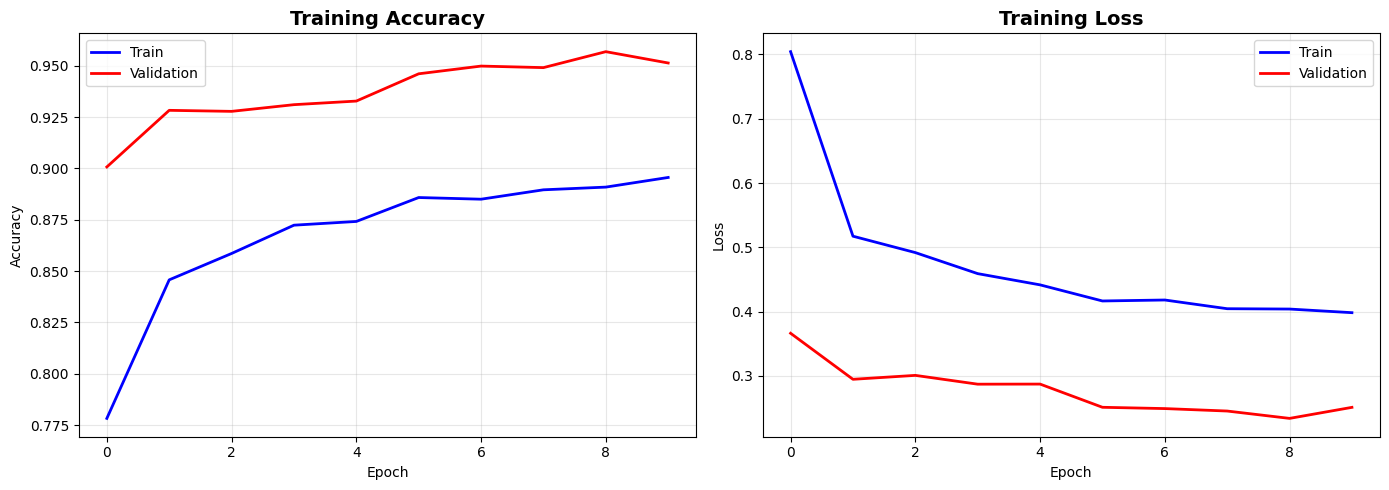

📊 Training curves saved to: E:\FasalVaidya\unified_savedmodel_output\training_history.png


In [65]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_stage3.history['accuracy'], 'b-', label='Train', linewidth=2)
axes[0].plot(history_stage3.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
axes[0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_stage3.history['loss'], 'b-', label='Train', linewidth=2)
axes[1].plot(history_stage3.history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[1].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Training curves saved to: {os.path.join(OUTPUT_DIR, 'training_history.png')}")

## 📦 Export Model (SavedModel Format)


In [69]:
# =============================================================
# 💾 EXPORT SAVEDMODEL FOR BACKEND
# =============================================================

print("📦 Exporting model to SavedModel format...")

savedmodel_path = OUTPUT_DIR / 'unified_savedmodel'

# Remove old if exists
if savedmodel_path.exists():
    shutil.rmtree(savedmodel_path)

# Export (Keras 3.x: use export() for SavedModel format)
model_stage3.export(str(savedmodel_path))

print(f"✅ SavedModel exported to: {savedmodel_path}")

# Save metadata
metadata = {
    'model_name': 'FasalVaidya Unified Nutrient Model',
    'version': '1.0.0-local',
    'created_at': datetime.now().isoformat(),
    'num_classes': num_classes,
    'class_names': class_names,
    'crops': list(CROP_DATASETS.keys()),
    'img_size': IMG_SIZE,
    'trained_on': 'Local CPU',
    'epochs': UNIFIED_EPOCHS,
    'batch_size': BATCH_SIZE,
    'best_val_accuracy': float(max(history_stage3.history['val_accuracy'])),
    'best_top3_accuracy': float(max(history_stage3.history['top3_acc']))
}

with open(savedmodel_path / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Save class labels
with open(savedmodel_path / 'labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

print(f"\n📄 Files created:")
print(f"   ├── saved_model.pb")
print(f"   ├── variables/")
print(f"   ├── metadata.json")
print(f"   └── labels.txt")

# Calculate size
total_size = sum(f.stat().st_size for f in savedmodel_path.rglob('*') if f.is_file()) / (1024 * 1024)
print(f"\n📊 Total size: {total_size:.1f} MB")

📦 Exporting model to SavedModel format...
INFO:tensorflow:Assets written to: E:\FasalVaidya\unified_savedmodel_output\unified_savedmodel\assets


INFO:tensorflow:Assets written to: E:\FasalVaidya\unified_savedmodel_output\unified_savedmodel\assets


Saved artifact at 'E:\FasalVaidya\unified_savedmodel_output\unified_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_162')
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  1524780244752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524780243600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524768602064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524768601296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524768595152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524768595920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524779833232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524779830928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524768600528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524768594000: TensorSpec(shape=(), dtype=tf.resource,

In [73]:
# =============================================================
# 🧪 TEST EXPORTED MODEL OUTPUT (DETAILED)
# =============================================================
import numpy as np

# Use TFSMLayer for inference from SavedModel (already loaded as inference_layer)
try:
    sample_batch = next(iter(val_nutrient))
    images, labels = sample_batch
    preds = inference_layer(images)
    if isinstance(preds, dict):
        # Try to extract the first tensor output from the dict
        first_key = list(preds.keys())[0]
        output = preds[first_key]
        print(f"Output key: {first_key}")
        print(f"Output shape: {output.shape}")
        print(f"Sample output (first 3):\n{output[:3]}")
    else:
        print(f"Output shape: {preds.shape}")
        print(f"Sample output (first 3):\n{preds[:3]}")
except Exception as e:
    print(f"Could not run sample prediction: {e}")

Output key: output_0
Output shape: (8, 18)
Sample output (first 3):
[[1.29649256e-04 1.79378465e-02 1.49130425e-03 1.71315522e-04
  9.69740927e-01 1.01742465e-02 1.55364796e-05 9.54057396e-05
  5.03001793e-05 1.22727024e-05 1.28262946e-05 1.43606394e-06
  3.12202392e-05 1.23309865e-05 1.85213539e-05 2.48700326e-06
  2.30392961e-05 7.92945939e-05]
 [1.54816207e-05 9.98965979e-01 7.48446701e-06 7.40163500e-07
  2.65506213e-04 7.37699273e-04 1.73631832e-07 8.82045583e-08
  1.36681109e-07 1.10846145e-06 8.54278639e-08 6.60089938e-08
  3.26175638e-07 4.32778933e-07 2.77202588e-07 1.14668225e-07
  3.42393378e-06 9.62239255e-07]
 [7.26935547e-03 2.02925344e-06 9.87369716e-01 1.23597295e-06
  5.58807340e-04 4.78734681e-03 1.42801559e-06 4.21444604e-08
  1.52260654e-07 8.12735038e-07 8.29929775e-07 2.11230031e-06
  1.06956782e-06 5.01006241e-07 9.56721237e-07 3.15459829e-07
  1.44893852e-06 1.96648421e-06]]


## 🎉 Training Complete!

### 📦 Next Steps

1. **Copy the SavedModel to your backend:**

   ```bash
   # Copy the entire folder
   cp -r "{OUTPUT_DIR}/unified_savedmodel" "backend/ml/models/"
   ```

2. **Test the model:**

   ```bash
   cd backend
   python test_unified.py
   ```

3. **Expected output:**
   ```
   N score: 75.3% (moderate deficiency)
   P score: 18.2% (healthy)
   K score: 6.5% (healthy)
   Detected: rice_Nitrogen(N)
   Confidence: 75.3%
   ```

### 📊 Model Info

Your model is now ready for deployment! It supports:

- 🌾 **4 crops:** Rice, Wheat, Tomato, Maize
- 🔬 **Multiple deficiencies:** N, P, K, and healthy classes
- 📱 **Real-time inference** on mobile and backend
- 🎯 **Expected accuracy:** 70-95% on deficient leaves

### 🚀 Performance Notes

This model was trained on CPU, which is slower but produces the same quality as GPU training. The final model will work just as well in production!

---
